# Load Save (Vanilla)

In [1]:
savename = "c:/Users/paulj/Desktop/prosjekt/pom_cpu-model/results/vanilla1_2024-12-03__18_44_11"

| **Parameter**                | **Value**      |
|------------------------------|----------------|
| Reward function type         | OpenPOM        |
| Similarity measure           | Cosine         |
| Graph building               | Vanilla Fragments      |
| Iterations                   | 500            |
| Max number of nodes          | 6              |
| Illegal action logreward     | -100           |
| β                            | 1              |
| Large molecule penalty       | None           |

## Imports

In [2]:
import sys
import os
path_to_top_dir = "../"
# Dynamically add the `project` directory to the path
sys.path.append(os.path.abspath(path_to_top_dir))

In [3]:
# Utils
import warnings

# Plotting
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import seaborn as sns
from pycirclize import Circos

# File management
import json
import numpy as np
import pandas as pd


# GFlowNET
import gflownet
from gflownet.algo.trajectory_balance import TrajectoryBalance
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.config import init_empty, Config
from scent_gfn.molecule import MoleculeTask

# OpenPOM
from pom_models.functions import fragance_propabilities_from_smiles

# Others
from tensorboard.backend.event_processing import event_accumulator
import torch
from rdkit import Chem





Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'
c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module impli

## Functions

In [4]:
def get_fragrance_notes():
    return list(pd.read_csv("../data/data.csv").keys()[2:])

In [5]:
def get_sorted_targed_scent_indicies(target):
    return np.argsort(-np.array(target))

In [6]:
def get_evaluated_objs_notes_df(objs):
    labels= get_fragrance_notes()
    data_lst  = []
    for i, obj in enumerate(objs):
        smiles = Chem.MolToSmiles(obj)
        probs = fragance_propabilities_from_smiles(smiles)[0]

        data_lst.append( [smiles] + list(probs))
    result_df = pd.DataFrame(
        data=data_lst,
        index=[i for i in range(len(data_lst))],
        columns=["smiles"]+list(labels)
        )
    return result_df


In [7]:
def get_target_notes_df(target):
    labels= get_fragrance_notes()
    target_df = pd.DataFrame(
        data=[["target"] + list(target)],
        columns=["smiles"]+list(labels),
        index=["Target"]
    )
    return target_df

In [8]:
def get_most_important_indicies(number,target):
    labels= get_fragrance_notes()
    indices=get_sorted_targed_scent_indicies(target)
    most_important_indicies = indices[:number]
    most_important_keys = []
    for i in most_important_indicies:
        most_important_keys.append(labels[i])
    return most_important_keys

In [9]:
def get_plot_df(objs,target, number,rewards):
    result_df = get_evaluated_objs_notes_df(objs)
    most_important_keys = get_most_important_indicies(number,target)
    return result_df[most_important_keys].set_index(pd.Series([f"{i+1} r:{rewards[i]:.2f}" for i in range(len(result_df["smiles"]))]))

In [10]:
def create_radar_grid_plot(objs,target, number,rewards,dim=[5,5], space=[1,0.25]):
    
    plot_df = get_plot_df(objs,target, number,rewards)
    plot_target_df= get_target_notes_df(target)[get_most_important_indicies(number,target)]
    #print(plot_df)
    #print(plot_target_df)
    # Create 5 x 5 subplots
    fig = plt.figure(figsize=(26, 16), dpi=100)
    fig.subplots(dim[0], dim[1], subplot_kw=dict(polar=True))
    fig.subplots_adjust(wspace=space[0], hspace=space[1])
    # Plot radar chart into subplots for each target
    for target_name, ax in zip(plot_df.index, fig.axes):
        target_df = plot_df.loc[[target_name]]
        target_df = pd.concat([target_df, plot_target_df])
        # Initialize Circos instance for radar chart plot
        circos = Circos.radar_chart(
            target_df,
            vmax=1,
            marker_size=6,
            #cmap=dict(Hero="salmon", Warrior="skyblue", Wizard="lime", Assassin="magenta"),
            grid_interval_ratio=0.2,
            line_kws_handler=lambda _: dict(lw=2, ls="solid"),
            marker_kws_handler=lambda _: dict(marker="D", ec="grey", lw=0.5),
        )

        # Plot figure & set legend on upper right
        circos.plotfig(ax=ax)
        circos.ax.legend(loc="upper right", fontsize=10,bbox_to_anchor=(1.7, 1.1))
    return fig

In [11]:
def read_pine_smiles():
    return list(pd.read_csv("../data/intensities.csv")["smiles"])

In [12]:
def read_vanilla_smiles():
    df = pd.read_csv("../data/data.csv")
    vanilla_mols_df = df.loc[df['vanilla'] == 1]
    vanilla_smiles_trainig= list(vanilla_mols_df["nonStereoSMILES"])
    
    return vanilla_smiles_trainig

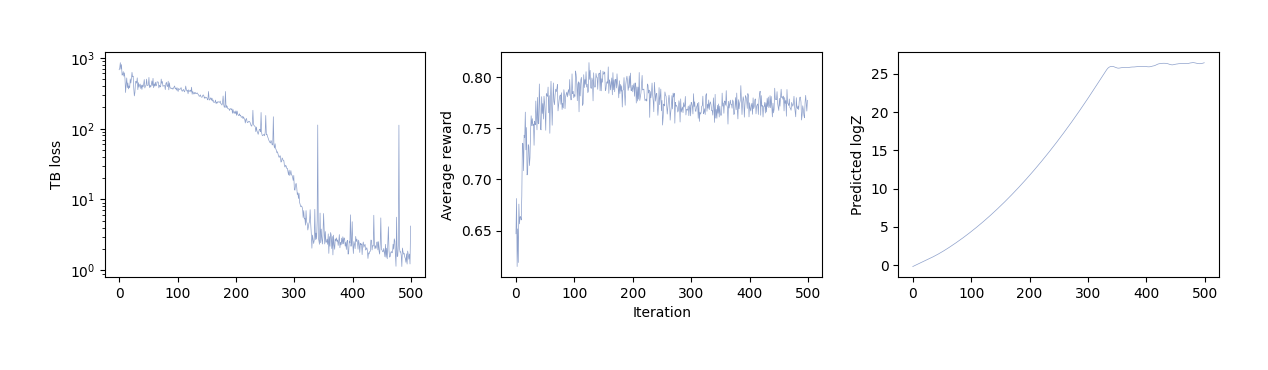

In [13]:

cfg = init_empty(Config())

cfg.log_dir = savename
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()


f, ax = plt.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')], color=sns.color_palette("Set2")[2])
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')], color=sns.color_palette("Set2")[2])
ax[1].set_ylabel('Average reward')
ax[1].set_xlabel('Iteration')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')], color=sns.color_palette("Set2")[2])
ax[2].set_ylabel('Predicted logZ')
plt.tight_layout()

In [14]:
# Model class must be defined somewhere
state = torch.load(os.path.join(cfg.log_dir, "model_final_save.pt"), weights_only=False)
#model = statemodel.eval()
#state["models_state_dict"]
config = state["cfg"]
env_ctx = state["env_ctx"]

In [15]:
with open(os.path.join(cfg.log_dir, "params.json"), "r") as file:
    params = json.load(file)

with open(os.path.join(cfg.log_dir, "target.json"), "r") as file:
    target = json.load(file)


In [16]:
model = gflownet.models.graph_transformer.GraphTransformerGFN(state["env_ctx"],state["cfg"])
model.load_state_dict(state["models_state_dict"][0])
model.eval()
1

1

In [17]:
#D:\Dokumenter\Skole\Prosjektoppgave\gflownet\src\gflownet\algo\trajectory_balance.py


algo = TrajectoryBalance(GraphBuildingEnv(),state["env_ctx"],state["cfg"])

In [18]:
task = MoleculeTask(data_tuple=(params["reward_func"], params["similarity"],params["large_mol_pen"], target, params["beta"]))

SMILES input data detected ...
Reward function: reward_function_openpom | Similarity measure: cosine_similarity | exp_penalty: False | max_mol=None


In [19]:
trajs = algo.create_training_data_from_own_samples(model, 12)

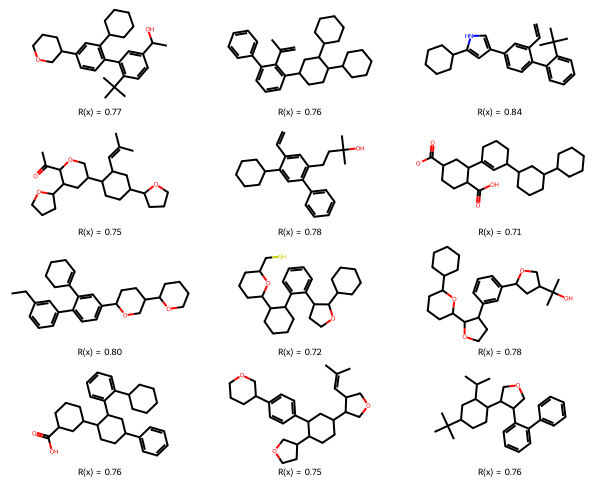

In [20]:
objs = [env_ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs))*params["beta"]}, obj_props)
index = 0
rewards = []
for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index].exp().item())
        index += 1 
    else:
        rewards.append(0.0)

MolsToGridImage(objs, molsPerRow=3, subImgSize=(200, 120), legends=[f'R(x) = {r:.2f}' for r in rewards])

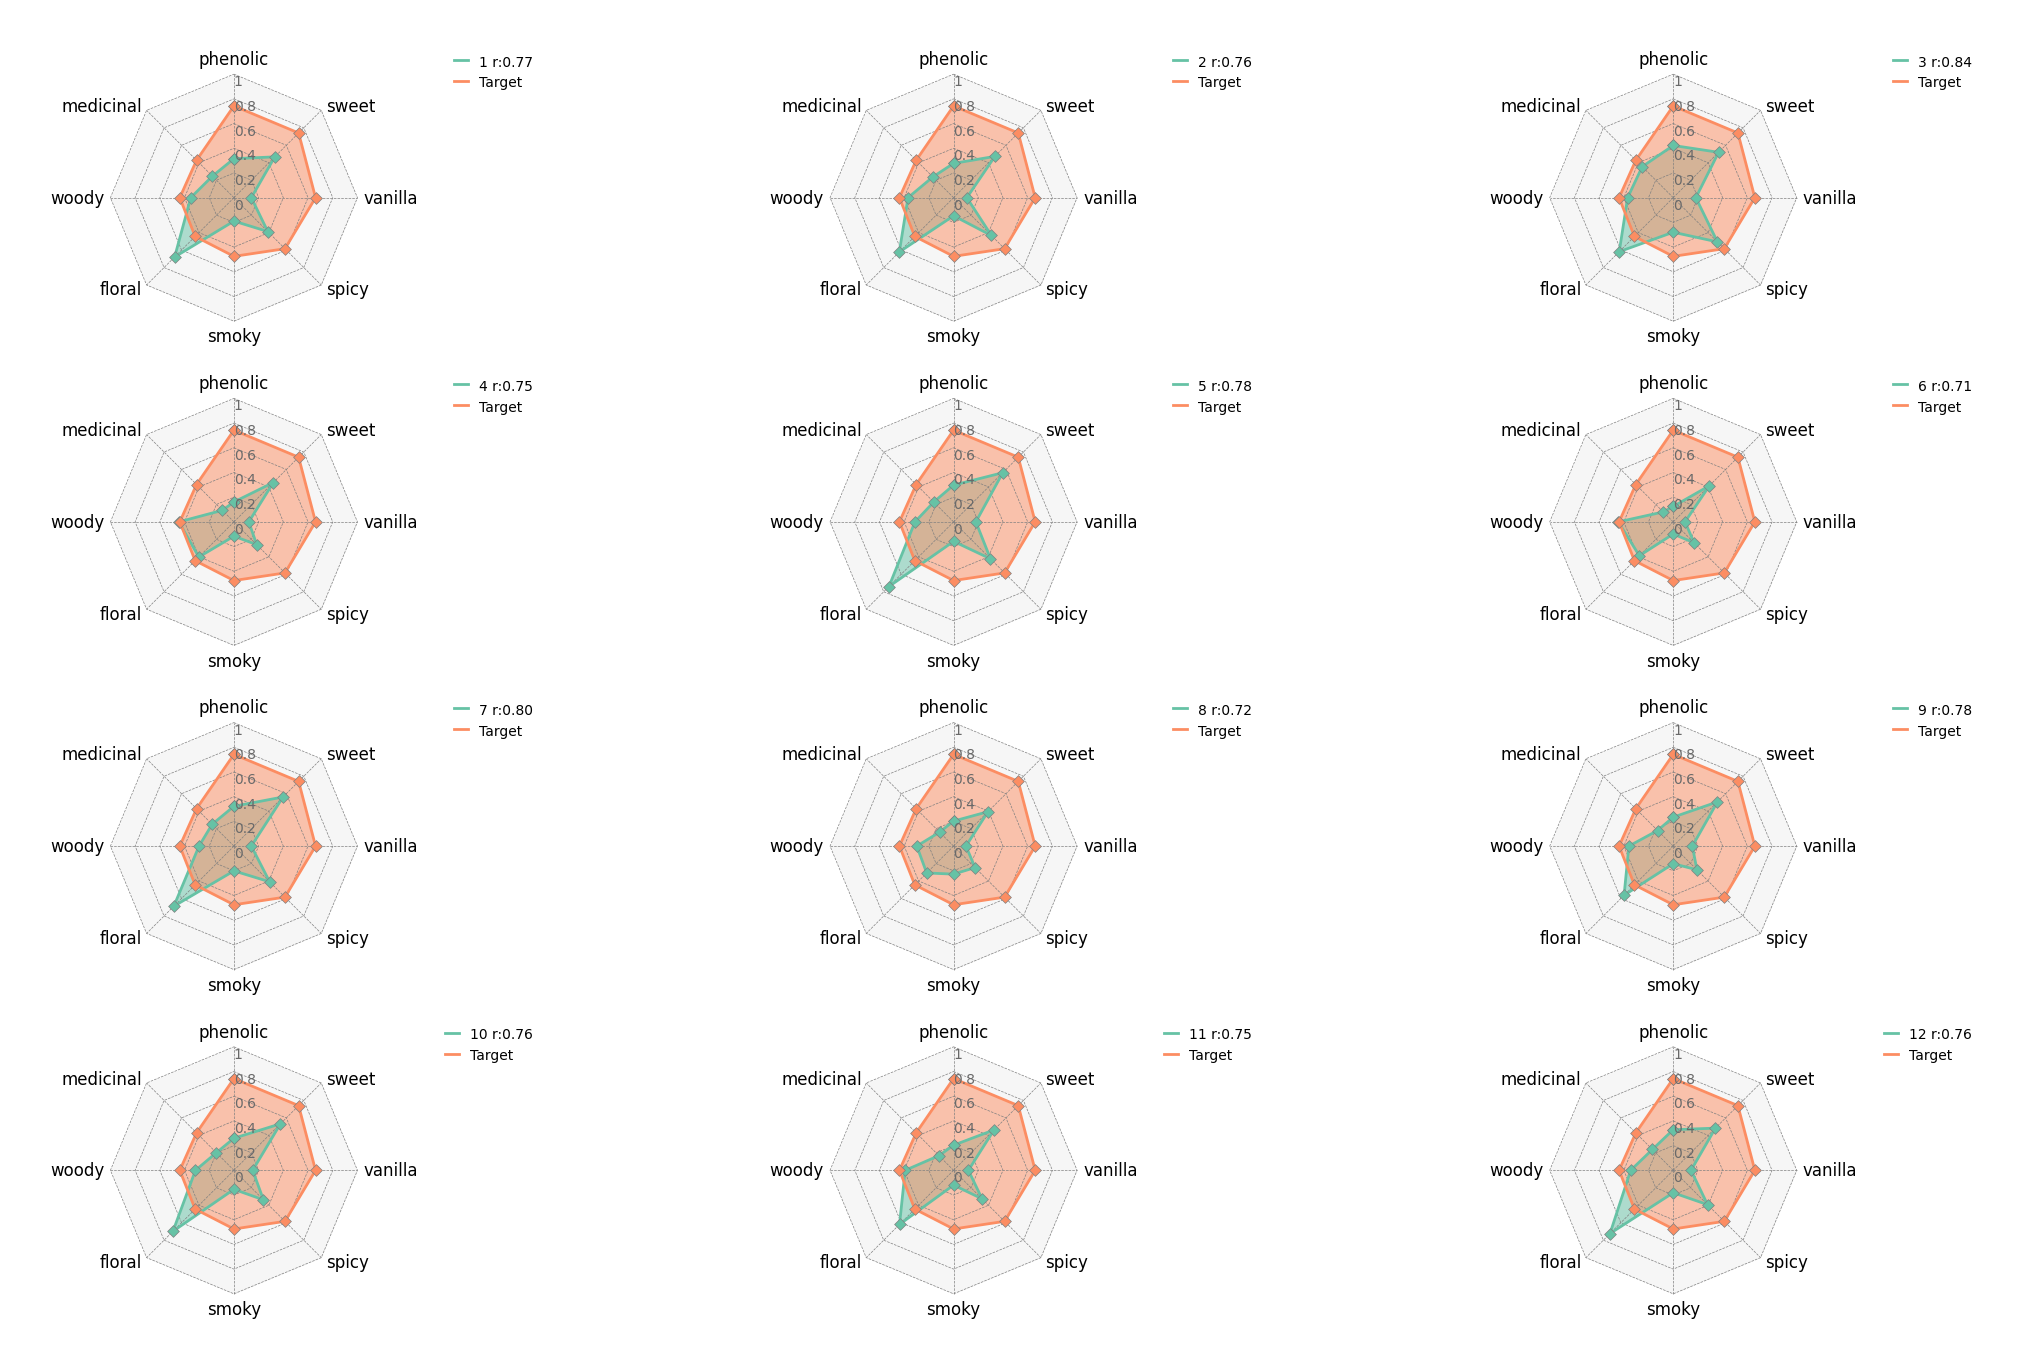

In [21]:
fig = create_radar_grid_plot(objs,fragance_propabilities_from_smiles(target[0])[0], 8,rewards,dim=[4,3],space=[0.25,0.25])

In [22]:
trajs1000 = algo.create_training_data_from_own_samples(model, 1000)

In [23]:
objs1000 = [env_ctx.graph_to_obj(i['result']) for i in trajs1000]

In [24]:

pine_data = [Chem.MolFromSmiles(s) for s in read_vanilla_smiles()]

# Generate canonical SMILES for comparison
objs1000_smiles_canon = [Chem.MolToSmiles(mol, canonical=True) for mol in objs1000]
pine_smiles_canon = [Chem.MolToSmiles(mol, canonical=True) for mol in pine_data]

# Check if molecules in list1 are in list2
contained_in_both = []
for smiles in pine_smiles_canon:
        if smiles in objs1000_smiles_canon:
            contained_in_both.append(smiles)

contained_in_both


[]